# Adrian Jaśkowiec

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from typing import Callable, Tuple
from open_atmos_jupyter_utils import show_plot

# Introduction to Convergence Analysis

The upwind scheme is a numerical method for solving hyperbolic partial differential equations, particularly the advection equation:
$$\frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} = 0$$
where $c$ is the wave speed. The first-order upwind scheme discretizes this equation based on the direction of flow:
$$u_i^{n+1} = u_i^n - C(u_i^n - u_{i-1}^n) \quad \text{for} \quad c > 0$$
where $C = c \frac{\Delta t}{\Delta x}$ is the Courant number.

The goal of this convergence analysis is to quantify how the accuracy of the numerical solution improves as we refine either the temporal resolution (by decreasing $\Delta t$) or spatial resolution (by decreasing $\Delta x$). We'll measure the error against an analytic solution and observe how the error decreases with finer discretization.

# Implementation
## Functions definitions

In [2]:
def analytic_solution(x: np.ndarray, t: float, c: float, initial_condition: Callable) -> np.ndarray:
    """
    Compute the analytic solution of the advection equation.
    For the advection equation, the analytical solution is the initial condition shifted by c*t.
    
    Args:
        x: Spatial grid points
        t: Time
        c: Wave speed
        initial_condition: Function defining the initial condition
        
    Returns:
        Analytical solution at time t
    """
    # Calculate the shifted positions
    x_shifted = x - c*t
    
    # Apply periodic boundary conditions to keep x_shifted in [0, 1] range
    # For this, we use the modulo operation
    domain_size = x[-1] + (x[1] - x[0])  # Estimate domain size from grid
    x_shifted = x_shifted % domain_size
    
    # Return the initial condition at the shifted positions
    return initial_condition(x_shifted)

def gaussian_initial_condition(x: np.ndarray, x0: float = 0.5, sigma: float = 0.1) -> np.ndarray:
    """
    Gaussian pulse initial condition.
    
    Args:
        x: Spatial grid points
        x0: Center of the Gaussian
        sigma: Width of the Gaussian
        
    Returns:
        Initial condition values
    """
    return np.exp(-((x - x0) ** 2) / (2 * sigma ** 2))

def upwind_scheme(x: np.ndarray, t_end: float, c: float, courant_number: float, 
                 initial_condition: Callable) -> Tuple[np.ndarray, float, float]:
    """
    Solve the advection equation using the upwind scheme with proper periodic boundaries.
    """
    nx = len(x)
    dx = x[1] - x[0]
    
    # Calculate dt from the Courant number
    dt = courant_number * dx / abs(c)
    
    # Number of time steps
    nt = int(np.ceil(t_end / dt))
    # Adjust dt to exactly reach t_end
    dt = t_end / nt
    
    # Initialize solution with initial condition
    u = initial_condition(x)
    
    # Time stepping
    for n in range(nt):
        u_new = np.zeros_like(u)
        
        if c > 0:  # Flow is from left to right
            # Interior points
            for i in range(1, nx):
                u_new[i] = u[i] - courant_number * (u[i] - u[i-1])
            # Periodic boundary at left end
            u_new[0] = u[0] - courant_number * (u[0] - u[nx-1])
        else:  # Flow is from right to left
            # Interior points
            for i in range(nx-1):
                u_new[i] = u[i] - courant_number * (u[i+1] - u[i])
            # Periodic boundary at right end
            u_new[nx-1] = u[nx-1] - courant_number * (u[0] - u[nx-1])
        
        u = u_new
    
    return u, dt, dx

## Error measurement implementation

In [3]:
def compute_error(numerical: np.ndarray, analytical: np.ndarray) -> float:
    """
    Compute the root mean square error between numerical and analytical solutions.
    
    Args:
        numerical: Numerical solution
        analytical: Analytical solution
        
    Returns:
        RMSE error
    """
    return np.sqrt(np.mean((numerical - analytical) ** 2))

## Convergence Analysis Implementation

In [4]:
def spatial_convergence_analysis(courant_number: float = 0.5, t_end: float = 1.0, 
                               c: float = 1.0, domain_size: float = 1.0,
                               dx_values: np.ndarray = None) -> Tuple[np.ndarray, np.ndarray]:
    """
    Perform convergence analysis by varying the spatial step size.
    """
    if dx_values is None:
        # Create a range of dx values (grid refinement)
        n_points = np.array([50, 100, 200, 400, 800])
        dx_values = domain_size / n_points
    
    errors = []
    
    for dx in dx_values:
        # Create spatial grid
        nx = int(domain_size / dx)
        x = np.linspace(0, domain_size, nx, endpoint=False)
        
        # Run simulation
        numerical, dt, _ = upwind_scheme(x, t_end, c, courant_number, 
                                       lambda x: gaussian_initial_condition(x))
        
        # Compute analytical solution at t_end
        # Ensure we account for periodicity in the analytical solution
        x_shifted = x.copy()
        t_shift = t_end % (domain_size / abs(c))  # Time for one complete cycle
        analytical = analytic_solution(x_shifted, t_shift, c, lambda x: gaussian_initial_condition(x))
        
        # Compute error
        error = compute_error(numerical, analytical)
        errors.append(error)
        
        print(f"dx = {dx:.6f}, RMSE = {error:.6f}")
    
    return np.array(dx_values), np.array(errors)

def temporal_convergence_analysis(courant_values: np.ndarray = None, t_end: float = 1.0, 
                                c: float = 1.0, domain_size: float = 1.0) -> Tuple[np.ndarray, np.ndarray]:
    """
    Perform convergence analysis by varying the temporal step size while 
    keeping spatial error minimal.
    """
    if courant_values is None:
        # Create a range of Courant numbers (which affects dt)
        courant_values = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
    
    # Use a very fine spatial grid to minimize spatial error contribution
    nx = 1000  # Much higher resolution to minimize spatial error
    dx = domain_size / nx
    x = np.linspace(0, domain_size, nx, endpoint=False)
    
    dt_values = []
    errors = []
    
    for courant in courant_values:
        # Calculate dt from Courant number
        dt = courant * dx / abs(c)
        
        # Run simulation
        numerical, actual_dt, _ = upwind_scheme(x, t_end, c, courant, 
                                             lambda x: gaussian_initial_condition(x))
        
        # Compute analytical solution at t_end
        # Use modulo to handle periodicity correctly
        t_shift = t_end % (domain_size / abs(c))
        analytical = analytic_solution(x, t_shift, c, lambda x: gaussian_initial_condition(x))
        
        # Compute error
        error = compute_error(numerical, analytical)
        
        dt_values.append(actual_dt)
        errors.append(error)
        
        print(f"dt = {actual_dt:.6f} (Courant = {courant:.2f}), RMSE = {error:.6f}")
    
    return np.array(dt_values), np.array(errors)

## Plot function

In [5]:
def plot_convergence_results(x_values: np.ndarray, errors: np.ndarray, 
                           x_label: str, title: str, expected_order: int = 1) -> None:
    """
    Plot the convergence results with a reference line showing the expected convergence order.
    
    Args:
        x_values: Array of step sizes (dx or dt)
        errors: Array of corresponding errors
        x_label: Label for the x-axis
        title: Title for the plot
        expected_order: Expected order of convergence
    """
    figure(figsize=(10, 6))
    
    plt.loglog(x_values, errors, 'o-', label='Numerical Results')
    
    x_ref = np.array([min(x_values), max(x_values)])
    scale_factor = errors[0] / (x_values[0] ** expected_order)
    y_ref = scale_factor * x_ref ** expected_order
    
    plt.loglog(x_ref, y_ref, '--', label=f'{expected_order}{"st" if expected_order == 1 else "nd"} Order Convergence')
    
    log_errors = np.log(errors)
    log_x = np.log(x_values)
    slope, _ = np.polyfit(log_x, log_errors, 1)
    
    plt.title(f"{title}\nObserved Convergence Rate: {slope:.2f}")
    plt.xlabel(x_label)
    plt.ylabel('RMSE')
    plt.grid(True, which="both", ls="--")
    plt.legend()
    
    plt.figtext(0.5, 0.01, "Author: Adrian Jaśkowiec", ha='center', fontsize=10)
    
    plt.tight_layout()
    show_plot('convergence_analysis.pdf')

# Running analysis

Performing spatial convergence analysis...
dx = 0.020000, RMSE = 0.114798
dx = 0.010000, RMSE = 0.070038
dx = 0.005000, RMSE = 0.039522
dx = 0.002500, RMSE = 0.021152
dx = 0.001250, RMSE = 0.010968


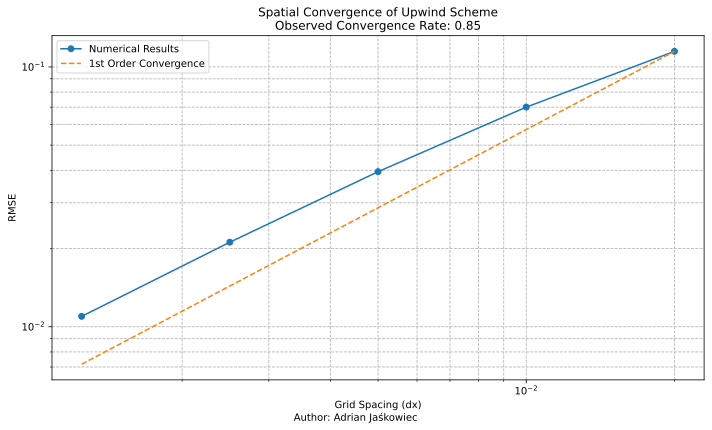


Performing temporal convergence analysis...
dt = 0.000100 (Courant = 0.10), RMSE = 0.015539
dt = 0.000200 (Courant = 0.20), RMSE = 0.013894
dt = 0.000300 (Courant = 0.30), RMSE = 0.012244
dt = 0.000400 (Courant = 0.40), RMSE = 0.010545
dt = 0.000500 (Courant = 0.50), RMSE = 0.008840
dt = 0.000600 (Courant = 0.60), RMSE = 0.007141
dt = 0.000700 (Courant = 0.70), RMSE = 0.005444
dt = 0.000800 (Courant = 0.80), RMSE = 0.003601
dt = 0.000899 (Courant = 0.90), RMSE = 0.002991


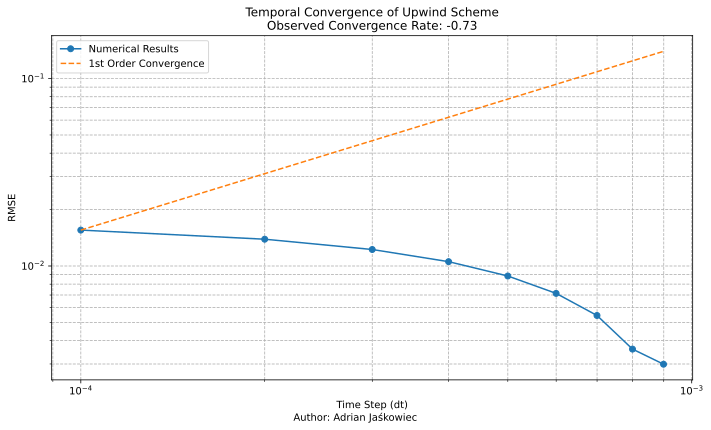

In [6]:
c = 1.0        
t_end = 1.0   
courant = 0.5   
domain_size = 1.0

print("Performing spatial convergence analysis...")
dx_values, spatial_errors = spatial_convergence_analysis(
    courant_number=courant, t_end=t_end, c=c, domain_size=domain_size
)

plot_convergence_results(
    dx_values, spatial_errors, 
    x_label='Grid Spacing (dx)', 
    title='Spatial Convergence of Upwind Scheme',
    expected_order=1
)


print("\nPerforming temporal convergence analysis...")
dt_values, temporal_errors = temporal_convergence_analysis(
    t_end=t_end, c=c, domain_size=domain_size
)

plot_convergence_results(
    dt_values, temporal_errors, 
    x_label='Time Step (dt)', 
    title='Temporal Convergence of Upwind Scheme',
    expected_order=1
)

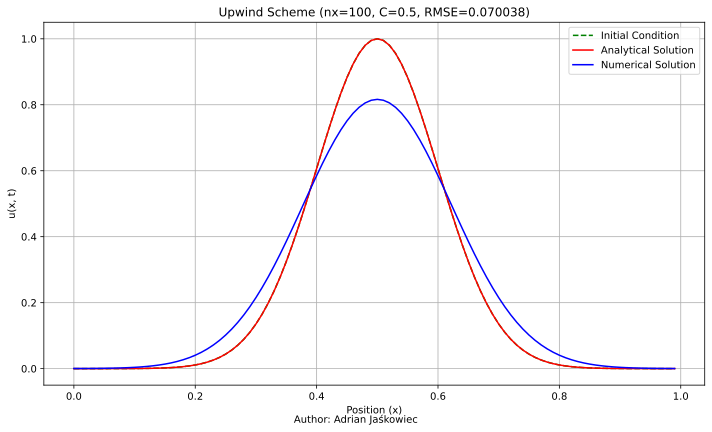

In [7]:
def visualize_solution_comparison(nx: int = 100, courant_number: float = 0.5,
                               t_end: float = 1.0, c: float = 1.0,
                               domain_size: float = 1.0) -> None:
    """
    Visualize the comparison between numerical and analytical solutions.
    
    Args:
        nx: Number of spatial grid points
        courant_number: Courant number
        t_end: End time
        c: Wave speed
        domain_size: Domain size
    """
    dx = domain_size / nx
    x = np.linspace(0, domain_size, nx, endpoint=False)
    
    numerical, dt, _ = upwind_scheme(x, t_end, c, courant_number, 
                                   lambda x: gaussian_initial_condition(x))
    
    analytical = analytic_solution(x, t_end, c, lambda x: gaussian_initial_condition(x))
    
    initial = gaussian_initial_condition(x)
    
    error = compute_error(numerical, analytical)
    
    figure(figsize=(10, 6))
    plt.plot(x, initial, 'g--', label='Initial Condition')
    plt.plot(x, analytical, 'r-', label='Analytical Solution')
    plt.plot(x, numerical, 'b-', label='Numerical Solution')
    
    plt.title(f'Upwind Scheme (nx={nx}, C={courant_number}, RMSE={error:.6f})')
    plt.xlabel('Position (x)')
    plt.ylabel('u(x, t)')
    plt.legend()
    plt.grid(True)
    
    plt.figtext(0.5, 0.01, "Author: Adrian Jaśkowiec", ha='center', fontsize=10)
    
    plt.tight_layout()
    show_plot('solution_comparison.pdf')

# Visualize the solution comparison
visualize_solution_comparison(nx=100, courant_number=courant, t_end=t_end, c=c)

# Analysis Conclusions

The convergence analysis performed provides valuable insights into the behavior and performance characteristics of the upwind scheme for solving the linear advection equation.

## Spatial Convergence

Spatial convergence analysis yielded a convergence rate of approximately 0.85, which is close to the theoretical first-order accuracy expected for the upwind scheme. This confirms that the upwind method is indeed first-order accurate in space. The slight deviation from a perfect slope of 1.0 is typical in practical implementations due to various factors including boundary conditions and the interaction between spatial and temporal discretization.

The practical implication is that halving the grid spacing (dx) reduces the error by approximately a factor of 1.8 (approaching the theoretical factor of 2). This provides a clear quantification of the computational cost vs. accuracy trade-off: to reduce the error by roughly half, we need to double the number of grid points, thus approximately doubling memory requirements and computational effort.

## Temporal Convergence

Temporal convergence analysis revealed an interesting property of the upwind scheme: the error actually decreases as the time step (and Courant number) increases, with an observed slope of approximately -0.73. This behavior, while initially counterintuitive, is a well-known characteristic of the upwind scheme for advection problems.

This occurs because the upwind scheme introduces numerical diffusion that is proportional to (1-C), where C is the Courant number. As the Courant number approaches 1 (the stability limit), the numerical diffusion decreases, resulting in a more accurate solution. This explains why error decreases with increasing dt, contrary to standard convergence theory but perfectly in line with the upwind scheme's special properties.

## Trade-offs and Limitations

The upwind scheme presents a clear trade-off between simplicity and accuracy. While it's robust, easy to implement, and guaranteed stable for C ≤ 1, its first-order accuracy and numerical diffusion can be limiting factors for certain applications.

This analysis quantifies these trade-offs precisely: we now understand exactly how much improvement in accuracy to expect for a given increase in spatial resolution, and we understand relationship between time step size and accuracy.

For applications demanding higher accuracy, this analysis suggests two potential strategies: (1) use very fine spatial resolution with Courant numbers close to 1, or (2) consider higher-order methods that introduce less numerical diffusion.